# **$\color{blue}{\text{MonReader: a computer vision appliction}}$**  

MonReader is a new mobile document digitization experience for the blind, for researchers and for everyone else in need for fully automatic, highly fast and high-quality document scanning in bulk. It is composed of a mobile app and all the user needs to do is flip pages and everything is handled by MonReader: it detects page flips from low-resolution camera preview and takes a high-resolution picture of the document, recognizing its corners and crops it accordingly, and it dewarps the cropped document to obtain a bird's eye view, sharpens the contrast between the text and the background and finally recognizes the text with formatting kept intact, being further corrected by MonReader's ML
 powered redactor.

* Data Description:   
The dataset was collected from page flipping video from smart phones and they was labelled as flipping and not flipping.
The videos were clipped as short videos and was labelled as flipping or not flipping. The extracted frames are then saved to disk in a sequential order with the following naming structure: VideoID_FrameNumber

* Goal(s):   
Predict if the page is being flipped using a single image.

* **$\color{blue}{\text{The planing of this work:}}$**       
1.   Data Exploration
2.   Splitting data into train, test and valid
3.   Data preprocessing
4.   Modelling part
5.   Results comparision
6.   Conclusion



*  First, let's install requirements

In [ ]:
!pip install efficientnet_pytorch

  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=12dd3e2380cd33591371febcd4c605fa8440b66d66b821776867b5200aa66d3e
  Stored in directory: /root/.cache/pip/wheels/0e/cc/b2/49e74588263573ff778da58cc99b9c6349b496636a7e165be6
Successfully built efficientnet-pytorch


In [ ]:
!pip install torchsummary

In [ ]:
!pip install grad-cam

     |████████████████████████████████| 4.5 MB 16.3 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for grad-cam: filename=grad_cam-1.3.7-py3-none-any.whl size=25953 sha256=f96f4adee3b6d08202251426a7955b23103149df8a684e7b8990ab48cf76d242
  Stored in directory: /root/.cache/pip/wheels/30/ab/9c/53c523785edffdc6c61755cf82e0dac3342d0d36190c187894
Successfully built grad-cam


* Import necessary libraries

In [ ]:
import warnings
warnings.filterwarnings('ignore')
import shutil 
from tqdm.notebook import tqdm
from __future__ import print_function, division
import pandas as pd
from torchsummary import  summary
from termcolor import colored
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import *
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from sklearn.metrics import classification_report, confusion_matrix
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
from torchvision import datasets
import json
import requests
import os
import time
import copy
import seaborn as sns
from sklearn.model_selection import train_test_split
from efficientnet_pytorch import EfficientNet
#grad cam
from pytorch_grad_cam import GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
cudnn.benchmark = True
plt.ion()   # interactive mode

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Set the random seed for both numpy and pytorch
np.random.seed(0)
torch.manual_seed(0)

In [ ]:
#set device as cuda if it's available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device,"==> is used")

cuda ==> is used


## 1- Data exploration



In [ ]:
# Get training and testing dataset 
train_flip_dir="/content/drive/MyDrive/flip/images/training/flip/"
train_flip = os.listdir(train_flip_dir)

train_notflip_dir ="/content/drive/MyDrive/flip/images/training/notflip/"
train_notflip = os.listdir(train_notflip_dir)

test_flip_dir= "/content/drive/MyDrive/flip/images/testing/flip/"
test_flip = os.listdir(test_flip_dir)

test_notflip_dir = "/content/drive/MyDrive/flip/images/testing/notflip/"
test_notflip = os.listdir(test_notflip_dir)

In [3]:
#See the shape of each data folder
print('total training fliped images:', len(train_flip)) 
print('total training not fliped images:', len(train_notflip))
print('total testing fliped images:', len(test_flip))
print('total testing not fliped images:', len(test_notflip))

total training fliped images: 1162
total training not fliped images: 1236
total testing fliped images: 290
total testing not fliped images: 307


* Define the smaller dimension in our image dataset

In [ ]:
# define empty lists to store shapes
height_list=[]
width_list=[]

In [ ]:
for l in [test_flip_dir,train_flip_dir, train_notflip_dir, test_notflip_dir]:
    liste=os.listdir(l)
    for i in liste:
        filename = os.path.join(l,i)
        img = Image.open(filename)
        height_list.append(img.size[1])
        width_list.append(img.size[0])

In [ ]:
print("the min width in the images data is:", min(width_list))
print("the min height in the images data is:", min(width_list))
#set the minimum size as a base for further cropping
base_size=(1080,1080)

the min width in the images data is: 1080
the min height in the images data is: 1080


In [ ]:
#take a test image example 
test_img=test_flip_dir+test_flip[0]
img = Image.open(test_img)
img.size

(1080, 1920)

As we can see, the dimensions of images are different, so we should unify it for all the dataset as 1080*1080. I will do this in the preprocessing section.

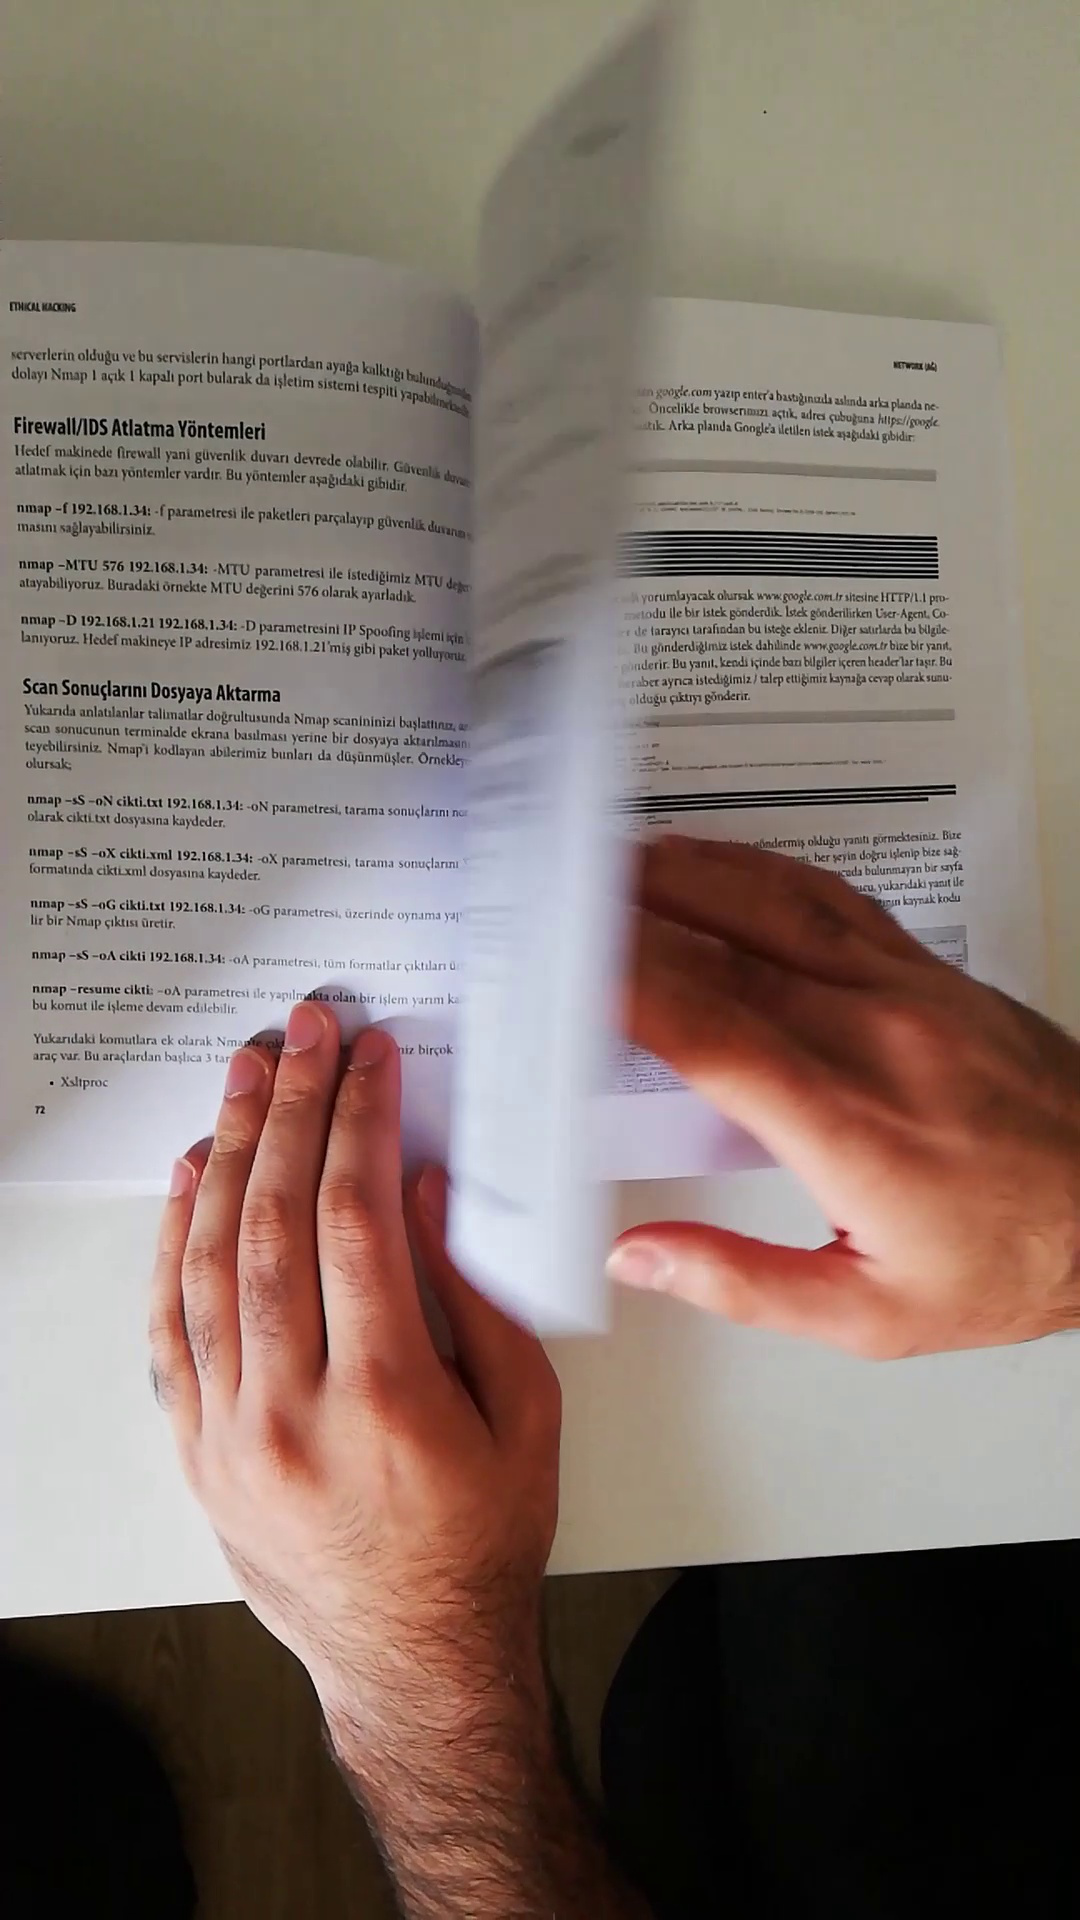

In [ ]:
#see the original image
img

## 2. Split training data into train/ valid

In [ ]:
X_noflip = np.array(train_notflip)
X_flip = np.array(train_flip)

#set 0 as flip and 1 as notflip
Y_noflip = np.ones(X_noflip.shape[0])
Y_flip = np.zeros(X_flip.shape[0])

X = np.concatenate((X_noflip,X_flip))
Y = np.concatenate((Y_noflip, Y_flip))

print(X.shape)
print(Y.shape)

(2398,)
(2398,)


In [ ]:
# Let's take 10% for the validation dataset
X_train, X_val, Y_train, Y_val = train_test_split(X, Y , test_size = 0.1, random_state = 100)
X_train.shape, X_val.shape, Y_train.shape, Y_val.shape

((2158,), (240,), (2158,), (240,))

* So, there is 240 images in the validation dataset and 2158 in training dataset

In [ ]:
#run this code for the first time only
'''os.mkdir('/content/drive/MyDrive/flip/images/valid')
valid_flip_dir='/content/drive/MyDrive/flip/images/valid/flip'
valid_notflip_dir='/content/drive/MyDrive/flip/images/valid/notflip'
os.mkdir(valid_flip_dir)
os.mkdir(valid_notflip_dir)

for i,j in zip(X_val,Y_val):
    if j ==0:# 0 --> flip
      shutil.move(train_flip_dir+i,valid_flip_dir)
    else:
      shutil.move(train_notflip_dir+i,valid_notflip_dir)'''

In [ ]:
#check size of folders
valid_flip_dir='/content/drive/MyDrive/flip/images/valid/flip'
valid_notflip_dir='/content/drive/MyDrive/flip/images/valid/notflip'
print(f'there are {len(os.listdir(valid_flip_dir))} images in the flip validation dataset')
print(f'there are {len(os.listdir(valid_notflip_dir))} images in the notflip validation dataset')
print('--------------> total valid is:',len(os.listdir(valid_flip_dir))+len(os.listdir(valid_notflip_dir)))

there are 112 images in the flip validation dataset
there are 128 images in the notflip validation dataset
--------------> total valid is: 240


## 3- Data preprocessing

In this step, I will prepare the dataset for the modeling part, by applying transformers including data augmentation.
I should notice that the preprocessing depends on the model I'll use.  

* Let's visulyse first the impact of some functions of image preprocessing on the test image used in the exploration section

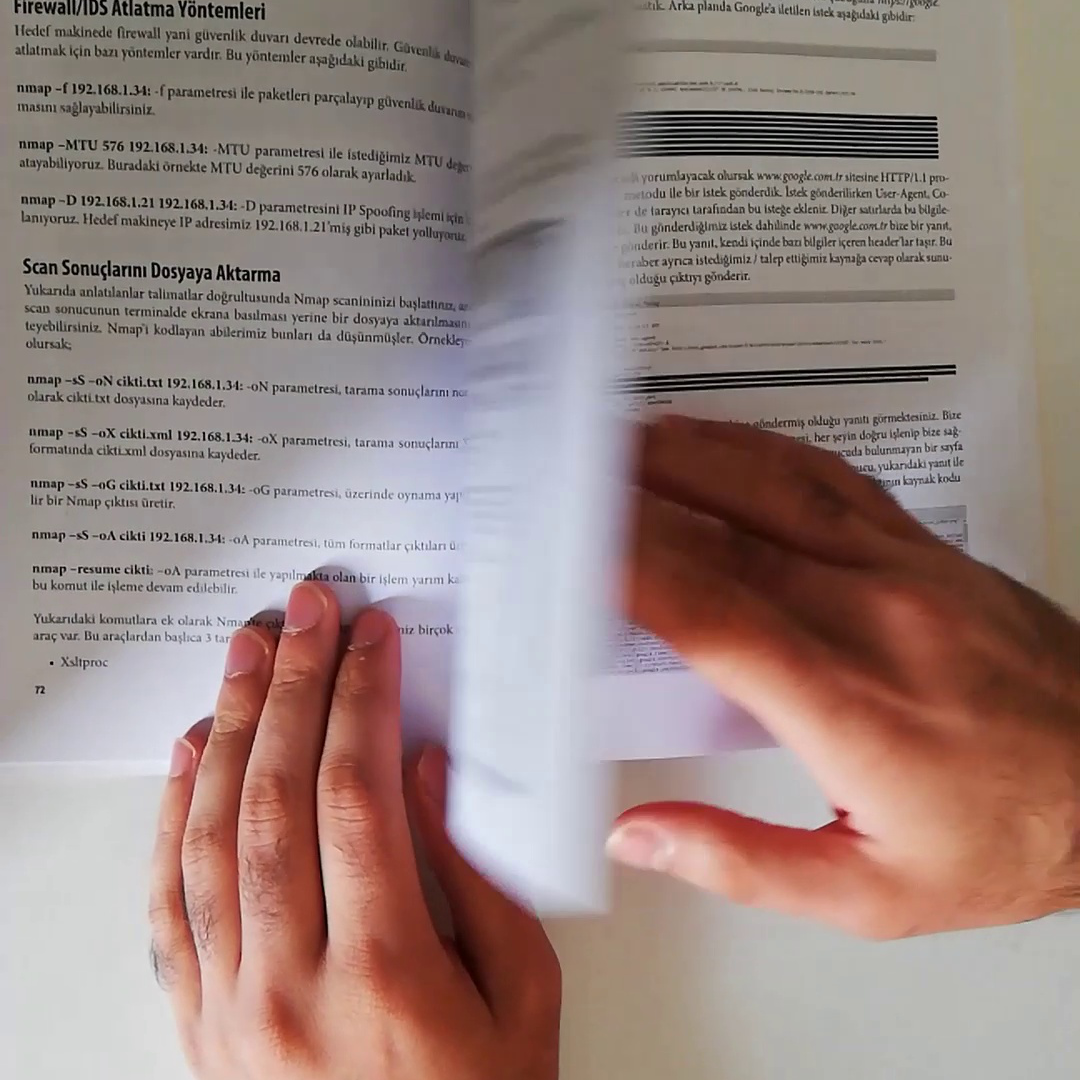

In [ ]:
#see the image after cropping it
cropped_img=transforms.CenterCrop(size=base_size)(img)
cropped_img

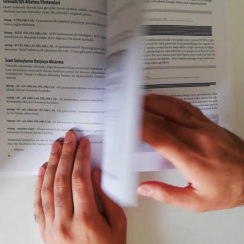

In [ ]:
#resize the cropped image
resized_img=transforms.Resize(size=(244,244))(cropped_img)
resized_img

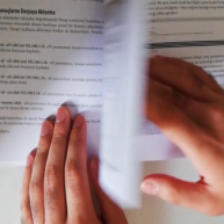

In [ ]:
transforms.RandomResizedCrop(224)(resized_img)

To organize more my work, I prefer to define transformers in this section that I'll use for each model further.
So, notice that I choose to use 3 kinds of models: 
1.  CNN architecture 
2.  ResNet model
3.  EfficentNet model

In [ ]:
#CNN transformer
CNN_transforms = {
    "training": transforms.Compose([
        transforms.CenterCrop(1080),  
        transforms.Resize((224, 224)),                          
        transforms.ToTensor()
    ]),
    "valid": transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()])
}

* Crope images to 1080*1080. 
* Resize all images to have size (224, 224) as well as convert them to tensor.
* The ToTensor operation convert all tensors to lie between (0, 1).

In [ ]:
#Resnet transformer
Resnet_transforms = {
    'training': transforms.Compose([
        transforms.CenterCrop(1080),                          
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [ ]:
#EfficentNet transformer
Efficentnet_transforms = {
    'training': transforms.Compose([
        transforms.CenterCrop(1080),  
        transforms.Resize(224),                                              
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(224), 
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

After initilizing the trasnformers, let's move to the next step, which is defining datasets.
Thus, I'll use 2 main functions: ImageFolder() and Dataloader.
ImageFolder saves the images and their respective labels according to the folders they’re present in, and the dataloader divides the data into different batches for training.  
* the shuffle argument to make sure the order of the data doesn’t affect the results.


In [ ]:
data_dir = "/content/drive/MyDrive/flip/images/"

In [ ]:
# For CNN
CNN_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          CNN_transforms[x])
                  for x in ['training', 'valid']}
                  
CNN_train_loader = DataLoader(dataset=CNN_datasets['training'], shuffle=True, batch_size=8)
CNN_val_loader = DataLoader(dataset=CNN_datasets['valid'], shuffle=True, batch_size=1)

In [ ]:
# For Resnet
Resnet_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          Resnet_transforms[x])
                  for x in ['training', 'valid']}
                  
Resnet_train_loader = DataLoader(dataset=Resnet_datasets['training'], shuffle=True, batch_size=8, num_workers=4)
Resnet_val_loader = DataLoader(dataset=Resnet_datasets['valid'], shuffle=True, batch_size=1, num_workers=4)

In [ ]:
# For EfficentNet
Efficentnet_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          Efficentnet_transforms[x])
                  for x in ['training', 'valid']}
                  
Efficentnet_train_loader = DataLoader(dataset=Efficentnet_datasets['training'], shuffle=True, batch_size=8, num_workers=4)
Efficentnet_val_loader = DataLoader(dataset=Efficentnet_datasets['valid'], shuffle=True, batch_size=1, num_workers=4)

* Let's visualize the distribution of training and testing datasets

In [ ]:
CNN_datasets['valid'].class_to_idx
idx2class = {v: k for k, v in CNN_datasets['valid'].class_to_idx.items()}
idx2class

{0: 'flip', 1: 'notflip'}

number of samples in flip class: 1050
number of samples in notflip class: 1108


Text(0.5, 1.0, 'Distribution of training dataset')

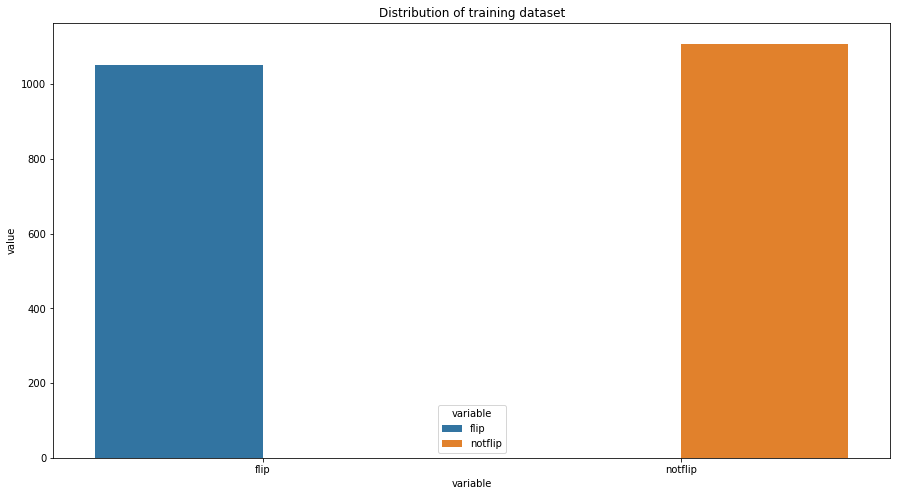

In [ ]:
def get_class_distribution(dataset_obj):
    count_dict = {k:0 for k,v in dataset_obj.class_to_idx.items()}
    for _, label_id in dataset_obj:
        label = idx2class[label_id]
        count_dict[label] += 1
    print("number of samples in flip class:", count_dict['flip'])
    print("number of samples in notflip class:", count_dict['notflip'])
    return count_dict
def plot_from_dict(dict_obj, plot_title, **kwargs):
    return sns.barplot(data = pd.DataFrame.from_dict([dict_obj]).melt(), x = "variable", y="value", hue="variable", **kwargs).set_title(plot_title)
plt.figure(figsize=(15,8))
plot_from_dict(get_class_distribution(CNN_datasets['training']), plot_title="Distribution of training dataset")

number of samples in flip class: 112
number of samples in notflip class: 128


Text(0.5, 1.0, 'Distribution of validation dataset')

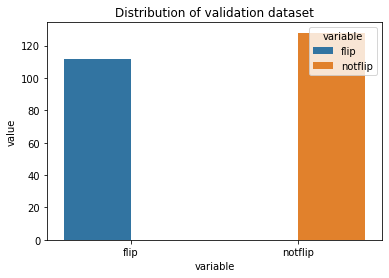

In [ ]:
plot_from_dict(get_class_distribution(CNN_datasets['valid']), plot_title="Distribution of validation dataset")

* From the plots above, we can infer the dataset is quite balanced

* Before moving to the modeling part, it will be great if we visualise images from dataloaders by batch as followed.

In [ ]:
inputs, classes = next(iter(CNN_train_loader))

* single_batch is a list of 2 elements. The first element contains the image tensors while the second element contains the output labels.

In [ ]:
#get size of the image tensor
inputs.shape
#(batch, channels, height, width)

torch.Size([8, 3, 224, 224])

In [ ]:
#Here are the output labels for the batch.
print("Output label tensors: ", classes)
print("\nOutput label tensor shape: ", classes.shape)

Output label tensors:  tensor([0, 0, 1, 0, 0, 1, 1, 1])

Output label tensor shape:  torch.Size([8])


To plot the image, we’ll use plt.imshow from matloptlib. It expects the image dimension to be (height, width, channels). We'll .permute() our single image tensor to plot it.

In [ ]:
# Selecting the first image tensor from the batch. 
single_image = inputs[5]
single_image.shape

torch.Size([3, 224, 224])

In [ ]:
#get class names
dataset_sizes = {x: len(CNN_datasets[x]) for x in ['training', 'valid']}
class_names = CNN_datasets['training'].classes
class_names

['flip', 'notflip']

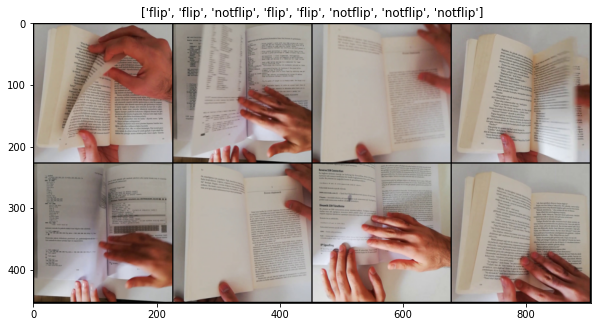

In [ ]:
# We do single_batch[0] because each batch is a list 
# where the 0th index is the image tensor and 1st index is the output label.
single_batch_grid = utils.make_grid(inputs, nrow=4)#  nrow: Number of images displayed in each row of the grid. 
plt.figure(figsize = (10,10))
plt.title([class_names[x] for x in classes])
plt.imshow(single_batch_grid.permute(1, 2, 0),)

## 4. Modeling part

In this section, I will train 3 different models on our dataset. Thus allow me to compare results. Let's go!

### 1. CNN model



* A. Training phase



This architecture is simple. I use 4 blocks of Conv layers. Each block consists of Convolution + BatchNorm + ReLU + Dropout layers.

In [ ]:
class flipClassifier(nn.Module):
    def __init__(self):
        super(flipClassifier, self).__init__()
        self.block1 = self.conv_block(c_in=3, c_out=256, dropout=0.1, kernel_size=5, stride=1, padding=2)
        self.block2 = self.conv_block(c_in=256, c_out=128, dropout=0.1, kernel_size=3, stride=1, padding=1)
        self.block3 = self.conv_block(c_in=128, c_out=64, dropout=0.1, kernel_size=3, stride=1, padding=1)
        self.lastcnn = nn.Conv2d(in_channels=64, out_channels=2, kernel_size=56, stride=1, padding=0)
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
    def forward(self, x):
        x = self.block1(x)
        x = self.maxpool(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.maxpool(x)
        x = self.lastcnn(x)
        return x
    def conv_block(self, c_in, c_out, dropout,  **kwargs):
        seq_block = nn.Sequential(
            nn.Conv2d(in_channels=c_in, out_channels=c_out, **kwargs),
            nn.BatchNorm2d(num_features=c_out),
            nn.ReLU(),
            nn.Dropout2d(p=dropout)
        )
        return seq_block

*  Using the nn.CrossEntropyLoss even though it's a binary classification problem. This means, instead of returning a single output of 1/0, we'll treat return 2 values of 0 and 1. More specifically, probabilities of the output being either 1 or 0.

In [ ]:
CNN_model = flipClassifier()
CNN_model.to(device)
print(CNN_model)
criterion = nn.CrossEntropyLoss()# 
optimizer = optim.Adam(CNN_model.parameters(), lr=0.001)

* We don’t have to manually apply a log_softmax layer after our final layer because nn.CrossEntropyLoss does that for us.
* However, we need to apply log_softmax for our validation and testing.

* This function below takes y_pred and y_test as input arguments. We then apply softmax to y_pred and extract the class which has a higher probability.
After that, we compare the predicted classes and the actual classes to calculate the accuracy.

In [ ]:
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_tag, dim = 1)
    correct_results_sum = (y_pred_tags == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    return acc

In [ ]:
#define 2 dictionaries which will store the accuracy/epoch and loss/epoch for both train and validation sets.
accuracy_stats_CNN = {
    'train': [],
    "val": []
}
loss_stats_CNN = {
    'train': [],
    "val": []
}

In [ ]:
print("Begin training.")
for e in tqdm(range(1, 21)):
    # TRAINING
    train_epoch_loss = 0
    train_epoch_acc = 0
    CNN_model.train()
    for X_train_batch, y_train_batch in CNN_train_loader:
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
        optimizer.zero_grad()
        y_train_pred = CNN_model(X_train_batch).squeeze()
        train_loss = criterion(y_train_pred, y_train_batch)
        train_acc = binary_acc(y_train_pred, y_train_batch)
        train_loss.backward()
        optimizer.step()
        train_epoch_loss += train_loss.item()
        train_epoch_acc += train_acc.item()
        
    # VALIDATION
    with torch.no_grad():
        CNN_model.eval()
        val_epoch_loss = 0
        val_epoch_acc = 0
        for X_val_batch, y_val_batch in CNN_val_loader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
            y_val_pred = CNN_model(X_val_batch).squeeze()
            y_val_pred = torch.unsqueeze(y_val_pred, 0)
            val_loss = criterion(y_val_pred, y_val_batch)
            val_acc = binary_acc(y_val_pred, y_val_batch)
            val_epoch_loss += val_loss.item()
            val_epoch_acc += val_acc.item()
    loss_stats_CNN['train'].append(train_epoch_loss/len(CNN_train_loader))
    loss_stats_CNN['val'].append(val_epoch_loss/len(CNN_val_loader))
    accuracy_stats_CNN['train'].append(train_epoch_acc/len(CNN_train_loader))
    accuracy_stats_CNN['val'].append(val_epoch_acc/len(CNN_val_loader))
    print(f'Epoch {e+0:02}: | Train Loss: {train_epoch_loss/len(CNN_train_loader):.5f} | Val Loss: {val_epoch_loss/len(CNN_val_loader):.5f} | Train Acc: {train_epoch_acc/len(CNN_train_loader):.3f}| Val Acc: {val_epoch_acc/len(CNN_val_loader):.3f}')

Begin training.


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 01: | Train Loss: 42.49950 | Val Loss: 17.27373 | Train Acc: 79.062| Val Acc: 85.804
Epoch 02: | Train Loss: 8.35384 | Val Loss: 2.25213 | Train Acc: 91.787| Val Acc: 96.660
Epoch 03: | Train Loss: 3.57422 | Val Loss: 1.43968 | Train Acc: 93.737| Val Acc: 96.242
Epoch 04: | Train Loss: 1.57361 | Val Loss: 1.45507 | Train Acc: 95.625| Val Acc: 95.616
Epoch 05: | Train Loss: 0.79984 | Val Loss: 0.52843 | Train Acc: 97.367| Val Acc: 97.912
Epoch 06: | Train Loss: 0.97734 | Val Loss: 1.67640 | Train Acc: 96.233| Val Acc: 94.363
Epoch 07: | Train Loss: 0.48248 | Val Loss: 0.49567 | Train Acc: 97.729| Val Acc: 97.704
Epoch 08: | Train Loss: 0.48155 | Val Loss: 0.28739 | Train Acc: 97.933| Val Acc: 98.121
Epoch 09: | Train Loss: 0.29211 | Val Loss: 0.53307 | Train Acc: 97.871| Val Acc: 96.660
Epoch 10: | Train Loss: 0.49020 | Val Loss: 0.34244 | Train Acc: 96.908| Val Acc: 96.660
Epoch 11: | Train Loss: 0.24416 | Val Loss: 0.60613 | Train Acc: 97.571| Val Acc: 97.286
Epoch 12: | Train L

* Check the plots of Loss and Accuracy history obtained after training the CNN model

Text(0.5, 1.0, 'Train-Val Loss/Epoch')

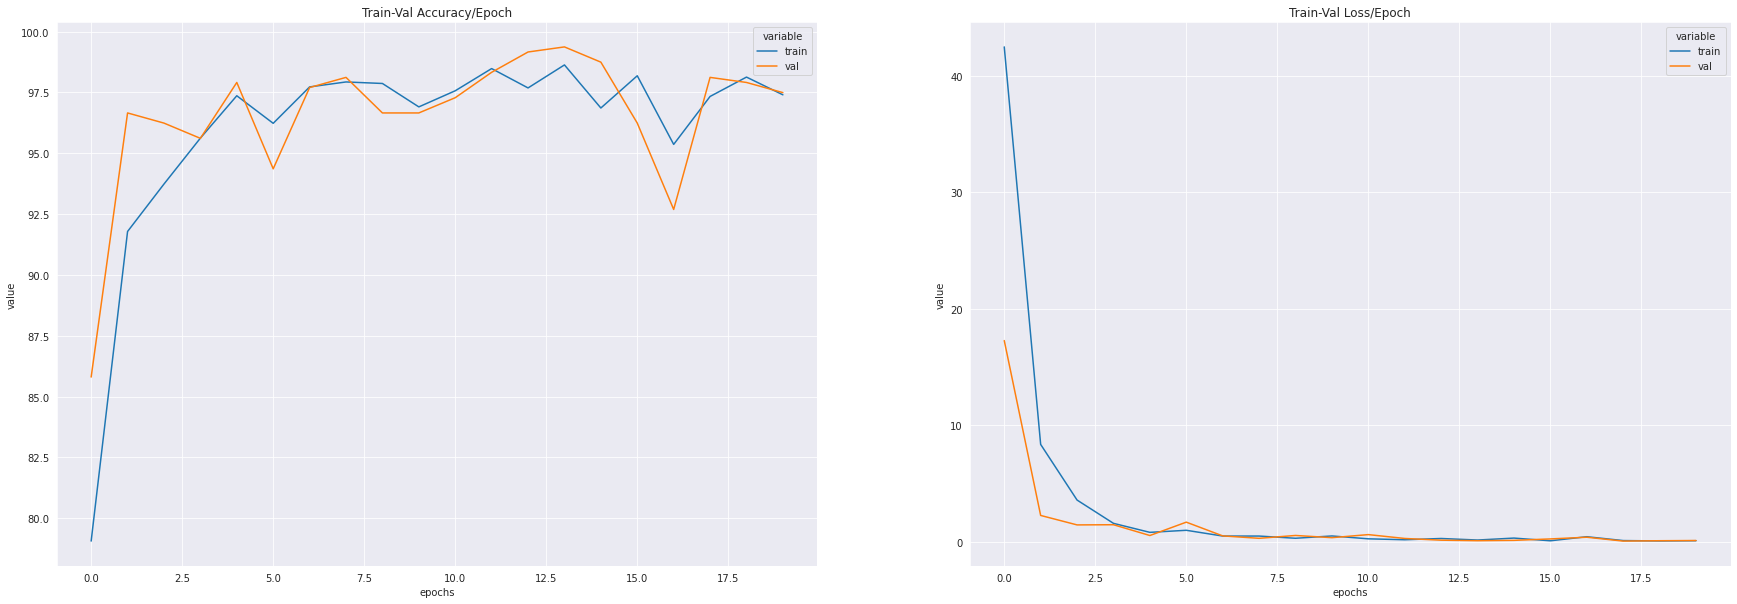

In [ ]:
train_val_acc_df = pd.DataFrame.from_dict(accuracy_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
train_val_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(30,10))
sns.lineplot(data=train_val_acc_df, x = "epochs", y="value", hue="variable",  ax=axes[0]).set_title('Train-Val Accuracy/Epoch')
sns.lineplot(data=train_val_loss_df, x = "epochs", y="value", hue="variable", ax=axes[1]).set_title('Train-Val Loss/Epoch')

* From the plot above, we can infer that there was no overfitting first during the training, also the loss and the accuracy start to be established.

In [ ]:
print("Model's state_dict:")
for param_tensor in CNN_model.state_dict():
    print(param_tensor, "\t", CNN_model.state_dict()[param_tensor].size())

Model's state_dict:
block1.0.weight 	 torch.Size([256, 3, 5, 5])
block1.0.bias 	 torch.Size([256])
block1.1.weight 	 torch.Size([256])
block1.1.bias 	 torch.Size([256])
block1.1.running_mean 	 torch.Size([256])
block1.1.running_var 	 torch.Size([256])
block1.1.num_batches_tracked 	 torch.Size([])
block2.0.weight 	 torch.Size([128, 256, 3, 3])
block2.0.bias 	 torch.Size([128])
block2.1.weight 	 torch.Size([128])
block2.1.bias 	 torch.Size([128])
block2.1.running_mean 	 torch.Size([128])
block2.1.running_var 	 torch.Size([128])
block2.1.num_batches_tracked 	 torch.Size([])
block3.0.weight 	 torch.Size([64, 128, 3, 3])
block3.0.bias 	 torch.Size([64])
block3.1.weight 	 torch.Size([64])
block3.1.bias 	 torch.Size([64])
block3.1.running_mean 	 torch.Size([64])
block3.1.running_var 	 torch.Size([64])
block3.1.num_batches_tracked 	 torch.Size([])
lastcnn.weight 	 torch.Size([2, 64, 56, 56])
lastcnn.bias 	 torch.Size([2])


In [ ]:
#save the model
torch.save(CNN_model.state_dict(), "/content/drive/MyDrive/flip/cnn_model.ckpt")

B.  Testing phase

The function below returns the accuracy of the test set as well as 2 lists to calculate further the confusion matrix

In [ ]:
#This function will be used for all models for testing
def valid_batch_loop(model_test,validloader):
        
        valid_loss = 0.0
        valid_acc = 0.0
        final_y_pred_list=[]
        final_y_true_list=[]
        for images,labels in tqdm(validloader):
            
            # move the data to CPU
            images = images.to(device) 
            labels = labels.to(device)
            logits = model_test(images)
            acc,y_pred_list,y_true_list=binary_acc_test(logits,labels)
            final_y_pred_list.extend(y_pred_list)
            final_y_true_list.extend(y_true_list)
            valid_acc = valid_acc + acc
            
        return valid_acc / len(validloader),final_y_pred_list,final_y_true_list

In [ ]:
#This function calculate the accuracy and 2 lists, one of predictions and the other for true labels for each input. 
def binary_acc_test(y_pred, y_test):
    y_pred_list=[]
    y_true_list=[]
    y_pred_tag = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_tag, dim = 1)
    correct_results_sum = (y_pred_tags == y_test).sum().float()
    y_pred_list.append(y_pred_tags.cpu().numpy())
    y_true_list.append(y_test.cpu().numpy())
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    return acc,y_pred_list,y_true_list

In [ ]:
#load the best model to our device
cnn_model = flipClassifier().to(device)
cnn_model.load_state_dict(torch.load('/content/drive/MyDrive/flip/cnn_model.ckpt'))

<All keys matched successfully>

In [ ]:
#define test dataset and test dataloader
CNN_test_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/flip/images/testing/', transform=CNN_transforms['valid'])
CNN_test_loader = DataLoader(dataset=CNN_test_dataset, shuffle=True, batch_size=1, num_workers=4)

In [ ]:
#define the eval mode
cnn_model.eval()
#Check the test accuracy
avg_test_acc_cnn,final_y_pred_list_cnn,final_y_true_list_cnn = valid_batch_loop(cnn_model,CNN_test_loader)
print("Test Acc cnn: {}".format(avg_test_acc_cnn))

  0%|          | 0/597 [00:00<?, ?it/s]

Test Acc cnn: 98.32495880126953


In [ ]:
print(classification_report([i[0] for i in final_y_true_list_cnn], [i[0][0][0] for i in final_y_pred_list_cnn],digits=4))

              precision    recall  f1-score   support

           0     0.9895    0.9759    0.9826       290
           1     0.9775    0.9902    0.9838       307

    accuracy                         0.9832       597
   macro avg     0.9835    0.9830    0.9832       597
weighted avg     0.9833    0.9832    0.9832       597



### $\color{blue}{\text{Great! these are good results for the first model. Let's choose the F1-score as a metric to compare with further models.}}$

### 2. Resnet

In [ ]:
#Define the training class
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                dataloaders=train_loader
                dataset_sizes=train_size
                model.train()  # Set model to training mode
            else:
                dataloaders=val_loader
                dataset_sizes=val_size
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes
            epoch_acc = running_corrects.double() / dataset_sizes

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
#Load the pretrained resnet18 model
model_ft = models.resnet18(pretrained=True)
#Get last output feature before the classification layer
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized, use SGD ooptimizer
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.5182 Acc: 0.7447
val Loss: 0.4953 Acc: 0.7996

Epoch 1/24
----------
train Loss: 0.3541 Acc: 0.8499
val Loss: 0.2197 Acc: 0.8977

Epoch 2/24
----------
train Loss: 0.3861 Acc: 0.8437
val Loss: 0.2678 Acc: 0.8873

Epoch 3/24
----------
train Loss: 0.2902 Acc: 0.8749
val Loss: 0.2000 Acc: 0.9248

Epoch 4/24
----------
train Loss: 0.2912 Acc: 0.8801
val Loss: 0.1439 Acc: 0.9395

Epoch 5/24
----------
train Loss: 0.2878 Acc: 0.8874
val Loss: 0.1473 Acc: 0.9436

Epoch 6/24
----------
train Loss: 0.2663 Acc: 0.8937
val Loss: 0.1217 Acc: 0.9562

Epoch 7/24
----------
train Loss: 0.1894 Acc: 0.9255
val Loss: 0.1113 Acc: 0.9562

Epoch 8/24
----------
train Loss: 0.2002 Acc: 0.9213
val Loss: 0.0823 Acc: 0.9708

Epoch 9/24
----------
train Loss: 0.2119 Acc: 0.9109
val Loss: 0.1152 Acc: 0.9541

Epoch 10/24
----------
train Loss: 0.1667 Acc: 0.9317
val Loss: 0.0871 Acc: 0.9666

Epoch 11/24
----------
train Loss: 0.1807 Acc: 0.9343
val Loss: 0.0800 Acc: 0.9708

Ep

In [ ]:
torch.save(model_ft.state_dict(), "/content/drive/MyDrive/flip/model_resnet.ckpt")

In [ ]:
#Fuction to visualize predictions
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(val_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(idx2class[preds[j].item()]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

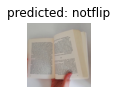

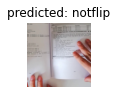

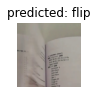

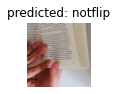

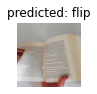

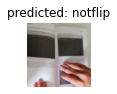

In [ ]:
visualize_model(model_ft)

B. Testing phase

In [ ]:
#load the best model to our device
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)
model_resnet = model_ft.to(device)
#load the best model to use it for testing
model_resnet.load_state_dict(torch.load('/content/drive/MyDrive/flip/model_resnet.ckpt'))

<All keys matched successfully>

In [ ]:
#define test data and apply transformer of resnet on it.
resnet_test_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/flip/images/testing/', transform=Resnet_transforms['valid'])
#Define the test dataloader whit batch size of 1
resnet_test_loader = DataLoader(dataset=resnet_test_dataset, shuffle=True, batch_size=1, num_workers=4)

In [ ]:
#define the eval mode 
model_resnet.eval()
#Chech the test accuracy
avg_test_acc_res,final_y_pred_list_res,final_y_true_list_res = valid_batch_loop(model_resnet,resnet_test_loader)
print("Test Acc : {}".format(avg_test_acc_res))

  0%|          | 0/597 [00:00<?, ?it/s]

Test Acc : 99.3299789428711


In [ ]:
print(classification_report([i[0] for i in final_y_true_list_res], [i[0] for i in final_y_pred_list_res],digits=4))

              precision    recall  f1-score   support

           0     0.9965    0.9897    0.9931       290
           1     0.9903    0.9967    0.9935       307

    accuracy                         0.9933       597
   macro avg     0.9934    0.9932    0.9933       597
weighted avg     0.9933    0.9933    0.9933       597



### $\color{blue}{\text{Awsome! This looks much better to the previous CNN model. The F1-score is 99.33% }}$

* Visualize with grad cam

In [ ]:
#Get the last layer from the model
target_layers = [model_resnet.layer4[-1]]
target_layers

[BasicBlock(
   (conv1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
   (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (relu): ReLU(inplace=True)
   (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
   (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
 )]

In [ ]:
#define testdata and apply transformer of resnet on it
resnet_test_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/flip/images/testing/', transform=Resnet_transforms['valid'])
#define the dataloader
resnet_test_loader = DataLoader(dataset=resnet_test_dataset, shuffle=False, batch_size=1, num_workers=4)

In [ ]:
#Construct the CAM object once, and then re-use it on many images
cam = GradCAM(model=model_resnet, target_layers=target_layers, use_cuda=True)

In [ ]:
#define the input tensor
single_batch = next(iter(resnet_test_loader))
input_tensor=single_batch[0]

In [ ]:
_,label= single_batch
label

tensor([0])

In [ ]:
#specify the target we want to generate, If targets is None, the highest scoring category
#Lest's choose the target 0 which is the class flip 
targets =[ClassifierOutputTarget(label)]
#targets=None

In [ ]:
file_name=resnet_test_loader.dataset.samples[0][0]
file_name

'/content/drive/MyDrive/flip/images/testing/flip/0001_000000020.jpg'

In [ ]:
grayscale_cam = cam(input_tensor=input_tensor, targets=targets)

In [ ]:
#Here grayscale_cam has only one image in the batch
grayscale_cam= grayscale_cam[0, :]

In [ ]:
image=Image.open(file_name)
image=image.resize((224,224))
image=np.asarray(image)
image=image/255

In [ ]:
#verify that max isn't upper to 1
np.max(image)

0.9568627450980393

In [ ]:
visualization = show_cam_on_image(image , grayscale_cam, use_rgb=False)

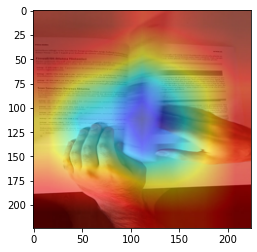

In [ ]:
#PLOT THE VISULIZATION
plt.imshow(visualization)

####  This looks comprehensive more. The models focus then on the position of hands as well as the page's position to detect whether is a flip case or not.

### 3. EfficentNet model
EfficientNets are a family of image classification models, which achieve state-of-the-art accuracy, being an order-of-magnitude smaller and faster. Trained with mixed precision using Tensor Cores.

In this section, we will use the pretrained EfficientNet model to perform inference on image and present the result.
We need some extra python packages installed. These are needed for preprocessing images and visualization.

In [ ]:
# For EfficentNet
Efficentnet_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          Efficentnet_transforms[x])
                  for x in ['training', 'valid']}
                  
Efficentnet_train_loader = DataLoader(dataset=Efficentnet_datasets['training'], shuffle=True, batch_size=8, num_workers=4)
Efficentnet_val_loader = DataLoader(dataset=Efficentnet_datasets['valid'], shuffle=True, batch_size=1, num_workers=4)
train_loader = DataLoader(dataset=image_datasets['training'], shuffle=True, batch_size=8, num_workers=4)
val_loader = DataLoader(dataset=image_datasets['valid'], shuffle=True, batch_size=1, num_workers=4)

In [ ]:
dataset_sizes = {x: len(Efficentnet_datasets[x]) for x in ['training', 'valid']}
class_names = Efficentnet_datasets['training'].classes
class_names

['flip', 'notflip']

the shape of the first image is: torch.Size([3, 224, 224])


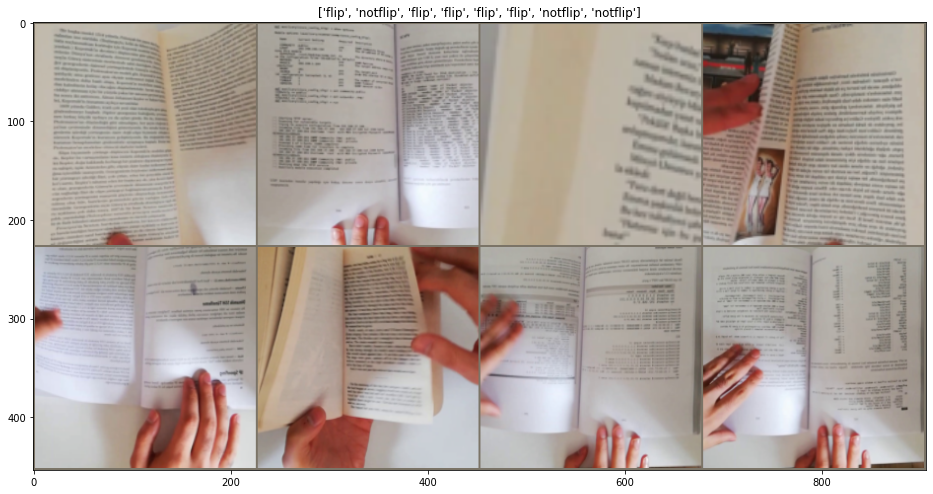

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    plt.figure(figsize=(16,16))
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated
# Get a batch of training data
inputs, classes = next(iter(Efficentnet_train_loader))
#see shape of the first image
print("the shape of the first image is:",inputs[0].shape)
# Make a grid from batch
out = torchvision.utils.make_grid(inputs, nrow=4)
imshow(out,title=[class_names[x] for x in classes])

In [ ]:
#load the B4 efficientnet model
B4_model=EfficientNet.from_pretrained('efficientnet-b4')
B4_model

Loaded pretrained weights for efficientnet-b4


EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        48, 48, kernel_size=(3, 3), stride=[1, 1], groups=48, bias=False
        (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
      )
      (_bn1): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        48, 12, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        12, 48, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        48, 24, kernel_siz

We have out_features=1000, so we need to update it to be 2 as we have a binary classification task

In [ ]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.B4_model = EfficientNet.from_pretrained('efficientnet-b4')
        
        self.fc = nn.Sequential(
                  nn.Linear(in_features=1000, out_features=512), #1000 is the last out_features
                  nn.ReLU(), #ReLu to be the activation function
                  nn.Dropout(p=0.3),
                  nn.Linear(in_features=512, out_features=2),
)
        
    def forward(self, x):
        x = self.B4_model(x)
        return self.fc(x)

In [ ]:
last_model=Model()
last_model

Loaded pretrained weights for efficientnet-b4


Model(
  (B4_model): EfficientNet(
    (_conv_stem): Conv2dStaticSamePadding(
      3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
    )
    (_bn0): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_depthwise_conv): Conv2dStaticSamePadding(
          48, 48, kernel_size=(3, 3), stride=[1, 1], groups=48, bias=False
          (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
        )
        (_bn1): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          48, 12, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dStaticSamePadding(
          12, 48, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_pro

In [ ]:
#chech the model's layers
last_model.to(device) 
summary(last_model,input_size=(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         ZeroPad2d-1          [-1, 3, 225, 225]               0
Conv2dStaticSamePadding-2         [-1, 48, 112, 112]           1,296
       BatchNorm2d-3         [-1, 48, 112, 112]              96
MemoryEfficientSwish-4         [-1, 48, 112, 112]               0
         ZeroPad2d-5         [-1, 48, 114, 114]               0
Conv2dStaticSamePadding-6         [-1, 48, 112, 112]             432
       BatchNorm2d-7         [-1, 48, 112, 112]              96
MemoryEfficientSwish-8         [-1, 48, 112, 112]               0
          Identity-9             [-1, 48, 1, 1]               0
Conv2dStaticSamePadding-10             [-1, 12, 1, 1]             588
MemoryEfficientSwish-11             [-1, 12, 1, 1]               0
         Identity-12             [-1, 12, 1, 1]               0
Conv2dStaticSamePadding-13             [-1, 48, 1, 1]             624
         I

In [ ]:
#define criterion, optimzer and scheduler for our model
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(last_model.parameters(), lr=0.001)
#scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.95)#Decays the learning rate of each parameter group by gamma every epoch. When last_epoch=-1, sets initial lr as lr.
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min',factor=0.1, patience=3)
#patience = 0, after 1 bad epoch, reduce LR

In [ ]:
#define 2 dictionaries which will store the accuracy/epoch and loss/epoch for both train and validation sets.
accuracy_stats = {
    'train': [],
    "val": []
}
loss_stats = {
    'train': [],
    "val": []
}

In [ ]:
print("Begin training.")
for e in tqdm(range(1, 20)):
    # TRAINING
    train_epoch_loss = 0
    train_epoch_acc = 0
    loss_best=0
    last_model.train()
    for X_train_batch, y_train_batch in Efficentnet_train_loader:
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
        optimizer.zero_grad()
        y_train_pred = last_model(X_train_batch).squeeze()
        #print('y_train_pred',y_train_pred)
        #print('y_train_batch',y_train_batch)
        train_loss = criterion(y_train_pred, y_train_batch)
        train_acc,_,_ = binary_acc(y_train_pred, y_train_batch)
        train_loss.backward()
        optimizer.step()
        train_epoch_loss += train_loss.item()
        train_epoch_acc += train_acc.item()
        
    # VALIDATION
    with torch.no_grad():
        last_model.eval()
        val_epoch_loss = 0
        val_epoch_acc = 0
        for X_val_batch, y_val_batch in Efficentnet_val_loader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
            y_val_pred = last_model(X_val_batch).squeeze()
            y_val_pred = torch.unsqueeze(y_val_pred, 0)
            val_loss = criterion(y_val_pred, y_val_batch)
            val_acc,_,_ = binary_acc(y_val_pred, y_val_batch)
            if loss_best==0:
                loss_best=val_loss.item()
            if val_loss.item()<loss_best:
                loss_best=val_loss.item()
                name_model='/content/drive/MyDrive/flip/efficentnet_bestmodel_3.ckpt'
                torch.save(last_model.state_dict(), name_model)
            val_epoch_loss += val_loss.item()
            val_epoch_acc += val_acc.item()
    loss_stats['train'].append(train_epoch_loss/len(Efficentnet_train_loader))
    loss_stats['val'].append(val_epoch_loss/len(Efficentnet_val_loader))
    accuracy_stats['train'].append(train_epoch_acc/len(Efficentnet_train_loader))
    accuracy_stats['val'].append(val_epoch_acc/len(Efficentnet_val_loader))
    scheduler.step(val_epoch_loss/len(Efficentnet_val_loader))
    print(f'Epoch {e+0:02}: | Train Loss: {train_epoch_loss/len(Efficentnet_train_loader):.5f} | Val Loss: {val_epoch_loss/len(Efficentnet_val_loader):.5f} | Train Acc: {train_epoch_acc/len(Efficentnet_train_loader):.3f}| Val Acc: {val_epoch_acc/len(Efficentnet_val_loader):.3f}')
    print("last lr",scheduler._last_lr)
    print('-'*20)
print("Training Finished")

Begin training.


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 01: | Train Loss: 0.55944 | Val Loss: 0.30399 | Train Acc: 74.811| Val Acc: 92.500
last lr [0.001]
--------------------
Epoch 02: | Train Loss: 0.44021 | Val Loss: 0.33524 | Train Acc: 81.767| Val Acc: 88.750
last lr [0.001]
--------------------
Epoch 03: | Train Loss: 0.38330 | Val Loss: 0.26063 | Train Acc: 84.544| Val Acc: 89.583
last lr [0.001]
--------------------
Epoch 04: | Train Loss: 0.38980 | Val Loss: 0.15065 | Train Acc: 84.322| Val Acc: 97.083
last lr [0.001]
--------------------
Epoch 05: | Train Loss: 0.36223 | Val Loss: 0.28587 | Train Acc: 85.307| Val Acc: 86.667
last lr [0.001]
--------------------
Epoch 06: | Train Loss: 0.34200 | Val Loss: 0.05722 | Train Acc: 87.515| Val Acc: 98.333
last lr [0.001]
--------------------
Epoch 07: | Train Loss: 0.33994 | Val Loss: 0.18770 | Train Acc: 87.152| Val Acc: 92.083
last lr [0.001]
--------------------
Epoch 08: | Train Loss: 0.30869 | Val Loss: 0.06439 | Train Acc: 88.156| Val Acc: 97.917
last lr [0.001]
-------------

Text(0.5, 1.0, 'Train-Val Loss/Epoch')

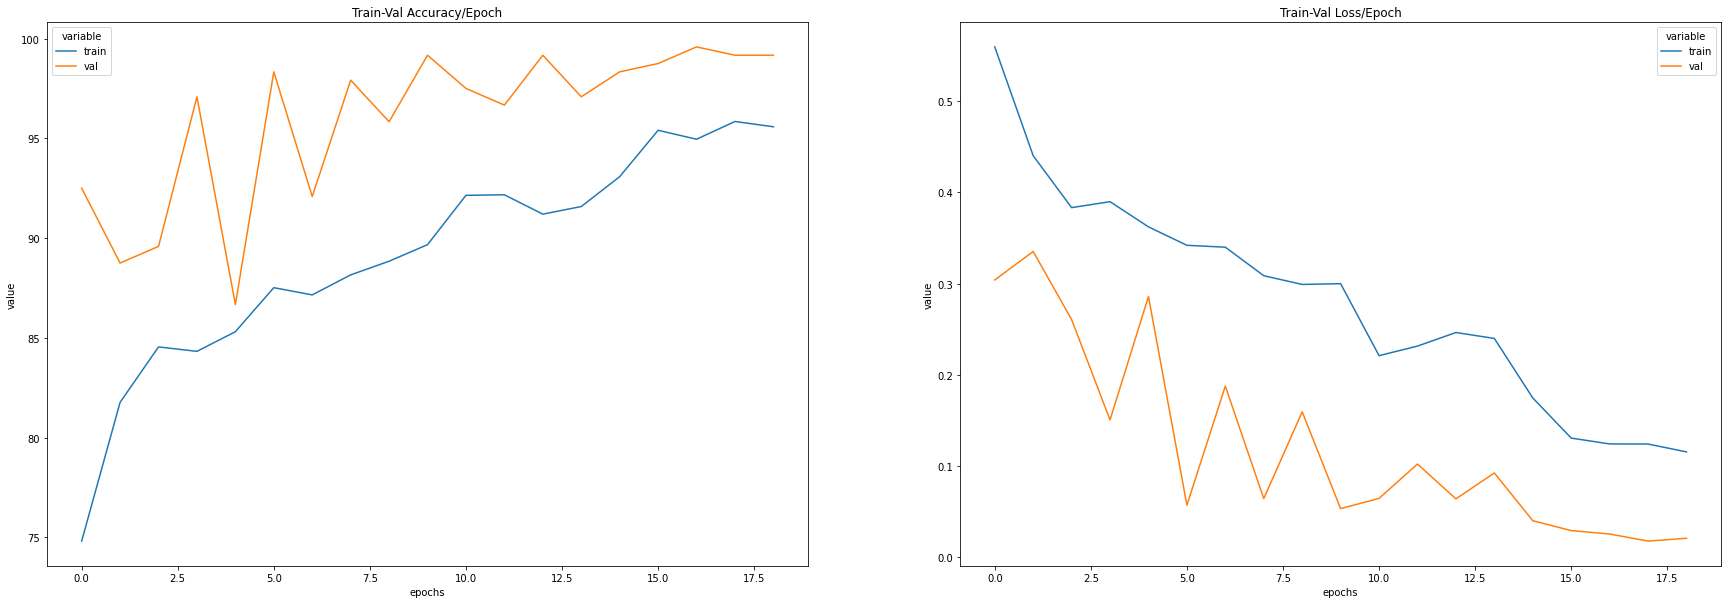

In [ ]:
train_val_acc_df = pd.DataFrame.from_dict(accuracy_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
train_val_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(30,10))
sns.lineplot(data=train_val_acc_df, x = "epochs", y="value", hue="variable",  ax=axes[0]).set_title('Train-Val Accuracy/Epoch')
sns.lineplot(data=train_val_loss_df, x = "epochs", y="value", hue="variable", ax=axes[1]).set_title('Train-Val Loss/Epoch')

From the above plots, we can infer that tere was no overfitting during the training. let's go to the test phase

* Test phase

In [ ]:
#define the CrossEntropyLoss criterion
criterion = nn.CrossEntropyLoss()

In [ ]:
#load the best model to our device
model_efficent = Model().to(device)
model_efficent.load_state_dict(torch.load('/content/drive/MyDrive/flip/efficentnet_bestmodel.ckpt'))

Loaded pretrained weights for efficientnet-b4


<All keys matched successfully>

In [ ]:
test_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/flip/images/testing/', transform=Efficentnet_transforms['valid'])

In [ ]:
test_loader = DataLoader(dataset=test_dataset, shuffle=True, batch_size=1, num_workers=4)

In [ ]:
model_efficent.eval()
avg_test_loss, avg_test_acc,final_y_pred_list,final_y_true_list = valid_batch_loop(model_efficent,test_loader)
#plot the accuracy and the loss of the test set
print("Test Loss : {}".format(avg_test_loss))
print("Test Acc : {}".format(avg_test_acc))

  0%|          | 0/599 [00:00<?, ?it/s]

Test Loss : 0.01684242451389433
Test Acc : 99.83305358886719


In [ ]:
print(classification_report([i[0] for i in final_y_true_list], [i[0] for i in final_y_pred_list],digits=4))

              precision    recall  f1-score   support

           0     1.0000    0.9966    0.9983       290
           1     0.9968    1.0000    0.9984       309

    accuracy                         0.9983       599
   macro avg     0.9984    0.9983    0.9983       599
weighted avg     0.9983    0.9983    0.9983       599



### $\color{blue}{\text{Wonderful! This looks the best score in comparision whith the previous models.       
Let's see the confusion matrix and see how many false predictions happened!}}$

In [ ]:
print(confusion_matrix(final_y_true_list, final_y_pred_list))

[[289   1]
 [  0 309]]


In [ ]:
idx2class = {v: k for k, v in test_dataset.class_to_idx.items()}
idx2class

{0: 'flip', 1: 'notflip'}

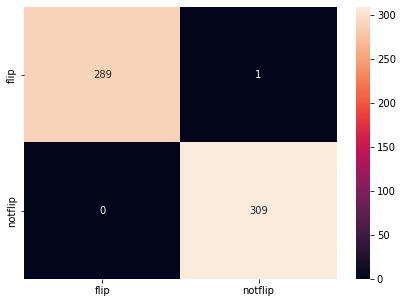

In [ ]:
confusion_matrix_df = pd.DataFrame(confusion_matrix(final_y_true_list, final_y_pred_list)).rename(columns=idx2class, index=idx2class)
fig, ax = plt.subplots(figsize=(7,5))         
sns.heatmap(confusion_matrix_df, annot=True, ax=ax, fmt='g')
#The default annotation format for heatmap is .2g which means a general format with 2 precision bytes. 
#Since these numbers require 3 bytes in their string representation this format will round and display in scientific notation. 
#Use g alone which defaults to a precision of 6

From the plot above, we can see that just 1 sample that was false predicted. Looks amazing so!

# 5. Results comparision
At the end, let's plot all results of the 3 choosen models. It seems that efficent net was the best one

In [ ]:
print(colored("\tComparision between CNN , Resent and EfficentNet models \n",'green'))
print('-'*72)
print('model           |   Accuracy    |   Precision  |  recall   |   F1-score')
print('-'*72)
print("CNN             |    98.66 %    |    98.71 %   |   98.63 % |   98.66 % ")
print("ResNet18        |    99.33 %    |    99.34 %   |   99.32 % |   99.33 % ")
print(colored("EfficentNet-b4  |    99.83 %    |    99.84 %   |   99.83 % |   99.83 % ", 'yellow'))

	Comparision between CNN , Resent and EfficentNet models 

------------------------------------------------------------------------
model           |   Accuracy    |   Precision  |  recall   |   F1-score
------------------------------------------------------------------------
CNN             |    98.66 %    |    98.71 %   |   98.63 % |   98.66 % 
ResNet18        |    99.33 %    |    99.34 %   |   99.32 % |   99.33 % 
EfficentNet-b4  |    99.83 %    |    99.84 %   |   99.83 % |   99.83 % 


# Conclusion

From the results and the analysis done on the previous sections, it seems that the architecture behind the Efficentnet model wasn't arbitrary. It was the best model with an F1-score of 99.83%, followed by Resnet18 with a value of 99.32%, followed by the CNN model with a value of 98.63%. 
Also, the accurate use of the data preprocessing and the data augmentation helps to improve highly the model's performance.